In [1]:
import pandas as pd
from datetime import datetime
import os
import sys
cwd = os.getcwd()
delimiter = "\\" if "\\" in cwd else "/"
repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
sys.path.append(repoPath + "dataImport/")
import rwWorkingTSDf
from rwWorkingTSDf import readWorkingTSDF


testdd = ["abhik", '0', "apple", 'AppleWatch-10-46mm', 'hr', 'builtin']
testdf = readWorkingTSDF(testdd)


read in 1503602 rows from 3 files, retruning 1503602 rows


In [2]:
testdf


,value
sampleDT,
2024-09-28 10:00:33+00:00,63.0
2024-09-28 10:00:38+00:00,56.0
2024-09-28 10:00:43+00:00,54.0
2024-09-28 10:00:44+00:00,54.0
2024-09-28 10:00:53+00:00,55.0
...,...
2025-01-14 20:05:36+00:00,89.0
2025-01-14 20:05:41+00:00,86.0
2025-01-14 20:05:50+00:00,94.0


In [8]:
start = pd.Timestamp("2024-10-15", tz="UTC")
print(start)
end = start + pd.Timedelta(days=1)
testdf.loc[start:end]

2024-10-15 00:00:00+00:00


,value
sampleDT,
2024-10-15 00:00:04+00:00,74.0
2024-10-15 00:00:05+00:00,74.0
2024-10-15 00:00:10+00:00,76.0
2024-10-15 00:00:15+00:00,76.0
2024-10-15 00:00:24+00:00,76.0
...,...
2024-10-15 23:59:36+00:00,85.0
2024-10-15 23:59:41+00:00,81.0
2024-10-15 23:59:43+00:00,81.0


In [3]:
# Utilities to plot a single day from a very large, UTC-indexed dataframe in Jupyter.
# Assumptions:
# - DataFrame index is named 'sampleDT' and is timezone-aware UTC (dtype: datetime64[ns, UTC])
# - Single column named 'value' (float)
#
# Features:
# - Fast day slicing
# - Adaptive downsampling to keep plotting responsive
# - Optional timezone conversion for display
# - Works for any sensor with the same format
#
# Usage examples (uncomment and adjust):
# plot_sensor_day(df, "2025-06-15")                           # plot UTC day
# plot_sensor_day(df, "2025-06-15", display_tz="America/Phoenix")  # plot but show times in local TZ
# plot_many_days({"hr": df_hr, "temp": df_temp}, "2025-06-15", display_tz="America/Phoenix")
#
# Notes:
# - For smoother zooming/panning, in Jupyter run one of:
#     %matplotlib widget   (requires ipympl installed)
#     %matplotlib notebook (classic Jupyter)
#     %matplotlib inline   (static, but toolbar still has zoom/pan)
#
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _ensure_utc_index(df: pd.DataFrame) -> pd.DataFrame:
    if df.index.name != "sampleDT":
        raise ValueError("Expected index named 'sampleDT'. Got: %r" % df.index.name)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a pandas DatetimeIndex.")
    # If tz-naive, assume it's UTC to avoid errors (user said UTC tz-aware, so this is a fallback)
    if df.index.tz is None:
        df = df.tz_localize("UTC")
    else:
        # Coerce to UTC if it's some other tz
        df = df.tz_convert("UTC")
    # Ensure column exists
    if "value" not in df.columns:
        raise KeyError("DataFrame must contain a 'value' column.")
    return df.sort_index()

def _slice_utc_day(df: pd.DataFrame, day_str: str) -> pd.DataFrame:
    # Interpret day_str as a UTC date (00:00 to 24:00)
    start = pd.Timestamp(day_str, tz="UTC")
    end = start + pd.Timedelta(days=1)
    return df.loc[start:end]

def _estimate_median_step_seconds(idx: pd.DatetimeIndex) -> float:
    if len(idx) < 2:
        return 1.0
    # Use median to be robust to spikes
    deltas = idx[1:] - idx[:-1]
    med = np.median(deltas.astype("timedelta64[ns]").astype(np.int64))
    # Convert ns to seconds
    return max(1.0e-9 * med, 1e-6)  # avoid zero

def _downsample(df: pd.DataFrame, target_points: int = 20000) -> pd.DataFrame:
    """Adaptive downsampling to keep ~target_points per plot. Uses time-based resampling to mean.
    Falls back to simple thinning if data is irregular or too sparse for resampling windows.
    """
    if len(df) <= target_points:
        return df

    # Estimate a resample rule based on typical spacing
    step_s = _estimate_median_step_seconds(df.index)
    if not np.isfinite(step_s) or step_s <= 0:
        step_s = 1.0

    # Desired bin width (in seconds)
    factor = math.ceil(len(df) / target_points)
    bin_seconds = max(int(math.ceil(step_s * factor)), 1)

    try:
        # Time-based resample (mean); preserves datetime index
        ds = df.resample(f"{bin_seconds}S").mean(numeric_only=True)
        # Drop NA-only bins that can appear at edges
        ds = ds.dropna(how="all")
        if len(ds) > 0:
            return ds
    except Exception:
        pass

    # Fallback: simple thinning by integer factor (keeps order)
    return df.iloc[::factor, :]

def plot_sensor_day(df: pd.DataFrame,
                    day: str,
                    display_tz: str | None = None,
                    target_points: int = 20000,
                    title: str | None = None):
    """
    Plot a single day from a UTC-indexed dataframe with a 'value' column.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with DatetimeIndex named 'sampleDT' (UTC) and a 'value' column.
    day : str
        Day to plot, e.g. '2025-06-15' (interpreted as a UTC day, 00:00..24:00).
    display_tz : str or None
        If provided (e.g., 'America/Phoenix'), converts the X-axis to that timezone for display.
    target_points : int
        Rough cap on the number of plotted points for interactivity.
    title : str or None
        Optional custom title.
    """
    df = _ensure_utc_index(df)
    day_df = _slice_utc_day(df, day)
    if day_df.empty:
        raise ValueError(f"No data found for UTC day {day}.")

    # Downsample to keep plotting responsive
    plot_df = _downsample(day_df[["value"]], target_points=target_points)

    # Convert to display tz for x-axis, if requested
    x = plot_df.index
    if display_tz:
        x = x.tz_convert(display_tz)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, plot_df["value"])
    ax.set_xlabel(f"time ({display_tz})" if display_tz else "time (UTC)")
    ax.set_ylabel("value")
    if title:
        ax.set_title(title)
    else:
        tz_note = f" → {display_tz}" if display_tz else ""
        ax.set_title(f"Sensor values for {day} (UTC day{tz_note}); n={len(day_df):,} → plotted {len(plot_df):,}")

    # Tighten layout for better readability
    fig.tight_layout()
    plt.show()

def plot_many_days(sensor_map: dict[str, pd.DataFrame],
                   day: str,
                   display_tz: str | None = None,
                   target_points: int = 20000):
    """
    Convenience: plot multiple sensors (one figure per sensor) with the same format.
    sensor_map: dict like {"hr": df_hr, "temp": df_temp}
    """
    for name, sdf in sensor_map.items():
        plot_sensor_day(sdf, day, display_tz=display_tz, target_points=target_points, title=f"{name} – {day}")


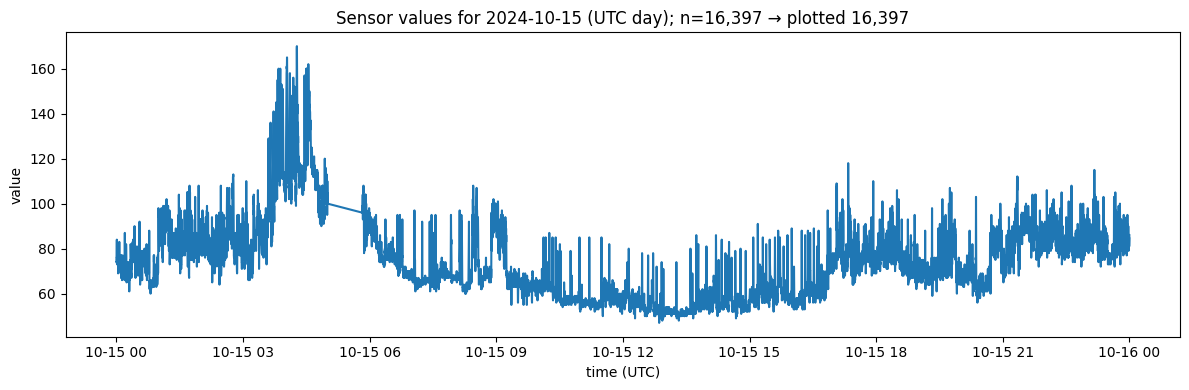

In [11]:
# Plot a UTC day
plot_sensor_day(testdf, "2024-10-15")

# Plot but show times in local timezone on the x-axis
#plot_sensor_day(testdf, "2024-10-15", display_tz="America/Phoenix")

# Multiple sensors (one figure per sensor)
#plot_many_days({"hr": df_hr, "temp": df_temp, "eda": df_eda}, "2025-06-15", display_tz="America/Phoenix")


In [23]:
# Updated plotting utilities with custom start/end windows and proper timezone-aware slicing.
# - You can now pass start/end in YOUR local time (or any tz), and the query window will be sliced in UTC correctly.
# - Convenience helper for a fixed 20-minute window.
#
# Usage examples:
#   # 20 minutes starting at 2025-06-15 08:00 America/Phoenix, display axis in the same tz
#   plot_sensor_20min(df, "2025-06-15 08:00", query_tz="America/Phoenix", display_tz="America/Phoenix")
#
#   # Arbitrary window with different query/display tz
#   plot_sensor_window(df, "2025-06-15 08:00", "2025-06-15 08:20",
#                      query_tz="America/Phoenix", display_tz="America/Phoenix")
#
#   # If your timestamps are already UTC and you want to input UTC times:
#   plot_sensor_window(df, "2025-06-15 15:00", "2025-06-15 15:20", query_tz="UTC", display_tz="UTC")
#
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _ensure_utc_index(df: pd.DataFrame) -> pd.DataFrame:
    #if df.index.name != "sampleDT":
    #    raise ValueError("Expected index named 'sampleDT'. Got: %r" % df.index.name)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a pandas DatetimeIndex.")
    if df.index.tz is None:
        # If tz-naive, assume timestamps are UTC (user stated UTC tz-aware; this is a fallback)
        df = df.tz_localize("UTC")
    else:
        df = df.tz_convert("UTC")
    #if "value" not in df.columns:
    #    raise KeyError("DataFrame must contain a 'value' column.")
    return df.sort_index()

def _parse_time(ts_like, tz: str) -> pd.Timestamp:
    """
    Parse a time-like input into a tz-aware pandas.Timestamp in the given timezone.
    - If input is tz-aware, convert to target tz.
    - If input is tz-naive (string or Timestamp), localize to target tz.
    """
    ts = pd.Timestamp(ts_like)
    if ts.tzinfo is None:
        ts = ts.tz_localize(tz)
    else:
        ts = ts.tz_convert(tz)
    return ts

def _to_utc(ts: pd.Timestamp) -> pd.Timestamp:
    return ts.tz_convert("UTC")

def _estimate_median_step_seconds(idx: pd.DatetimeIndex) -> float:
    if len(idx) < 2:
        return 1.0
    deltas = idx[1:] - idx[:-1]
    med = np.median(deltas.astype("timedelta64[ns]").astype(np.int64))
    return max(1.0e-9 * med, 1e-6)

def _downsample(df: pd.DataFrame, target_points: int = 20000) -> pd.DataFrame:
    if len(df) <= target_points:
        return df
    step_s = _estimate_median_step_seconds(df.index)
    if not np.isfinite(step_s) or step_s <= 0:
        step_s = 1.0
    factor = math.ceil(len(df) / target_points)
    bin_seconds = max(int(math.ceil(step_s * factor)), 1)
    try:
        ds = df.resample(f"{bin_seconds}S").mean(numeric_only=True).dropna(how="all")
        if len(ds) > 0:
            return ds
    except Exception:
        pass
    return df.iloc[::factor, :]

def slice_window(df: pd.DataFrame, start, end, query_tz: str = "UTC") -> pd.DataFrame:
    """
    Return df between start and end (inclusive) where start/end are interpreted in query_tz,
    and slicing is done in UTC.
    """
    df = _ensure_utc_index(df)
    start_q = _parse_time(start, query_tz)
    end_q = _parse_time(end, query_tz)
    if end_q <= start_q:
        raise ValueError("end must be after start.")
    # Convert query window to UTC for slicing
    start_utc = _to_utc(start_q)
    end_utc = _to_utc(end_q)
    return df.loc[start_utc:end_utc]

def plot_sensor_window(df: pd.DataFrame,
                       start,
                       end,
                       query_tz: str = "America/Phoenix",
                       display_tz: str | None = "America/Phoenix",
                       target_points: int = 20000,
                       title: str | None = None):
    """
    Plot df['value'] between start and end, where start/end are interpreted in query_tz.
    The x-axis can be shown in display_tz (defaults to query_tz for convenience).
    """
    if display_tz is None:
        display_tz = query_tz
    win = slice_window(df, start, end, query_tz=query_tz)
    if win.empty:
        raise ValueError(f"No data found in window [{start} .. {end}] ({query_tz}).")
    plot_df = _downsample(win[["value"]], target_points=target_points)

    x = plot_df.index.tz_convert(display_tz)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, plot_df["value"])
    ax.set_xlabel(f"time ({display_tz})")
    ax.set_ylabel("value")

    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{start} → {end} ({query_tz} window); plotted {len(plot_df):,}/{len(win):,} pts")

    fig.tight_layout()
    plt.show()

def plot_sensor_20min(df: pd.DataFrame,
                      start,
                      query_tz: str = "America/Phoenix",
                      display_tz: str | None = "America/Phoenix",
                      target_points: int = 20000,
                      title: str | None = None):
    """
    Convenience: plot a fixed 20-minute window starting at 'start' interpreted in query_tz.
    """
    start_q = _parse_time(start, query_tz)
    end_q = start_q + pd.Timedelta(minutes=20)
    return plot_sensor_window(df, start_q, end_q,
                              query_tz=query_tz,
                              display_tz=display_tz,
                              target_points=target_points,
                              title=title)


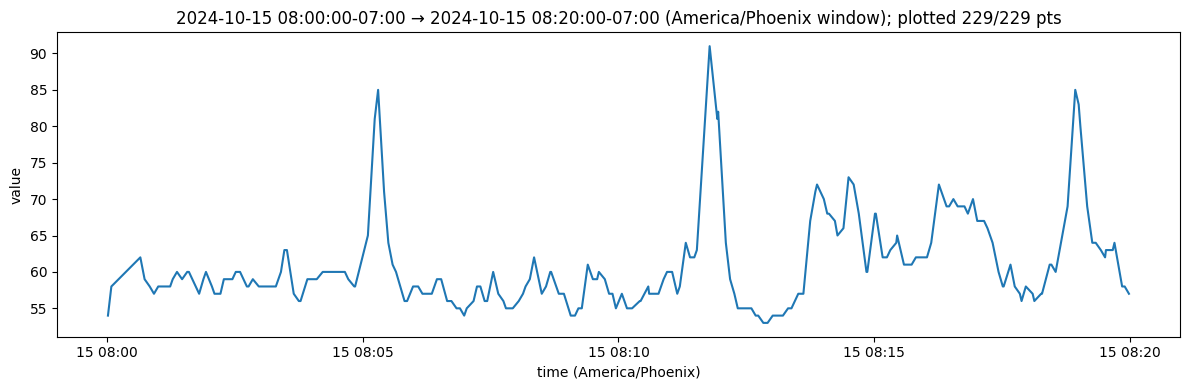

In [13]:
# 20-minute window starting at 8:00am Phoenix time, show axis in Phoenix
plot_sensor_20min(testdf, "2024-10-15 08:00",
                  query_tz="America/Phoenix",
                  display_tz="America/Phoenix")

# Arbitrary window, pass explicit start/end in Phoenix time
#plot_sensor_window(df,
#                   "2025-06-15 08:00", "2025-06-15 08:20",
#                   query_tz="America/Phoenix",
#                   display_tz="America/Phoenix")

# If you want to input UTC times and display UTC:
#plot_sensor_window(df,
#                   "2025-06-15 15:00", "2025-06-15 15:20",
#                   query_tz="UTC",
#                   display_tz="UTC")


read in 19691601 rows from 54 files, retruning 19691601 rows


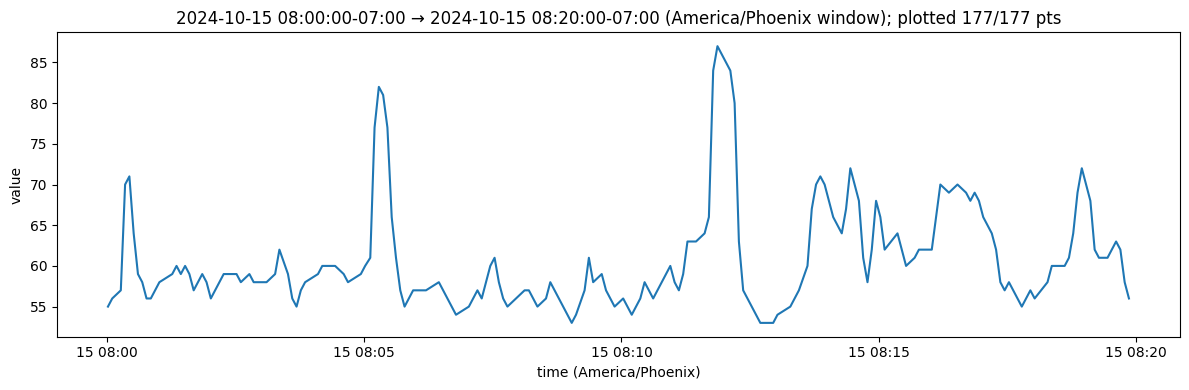

In [14]:
deviceDescriptor = ["abhik", "0", "fitbit", "charge4or5", "hr", "builtin"]
fitbitdf = readWorkingTSDF(deviceDescriptor)
plot_sensor_20min(fitbitdf, "2024-10-15 08:00",
                  query_tz="America/Phoenix",
                  display_tz="America/Phoenix")

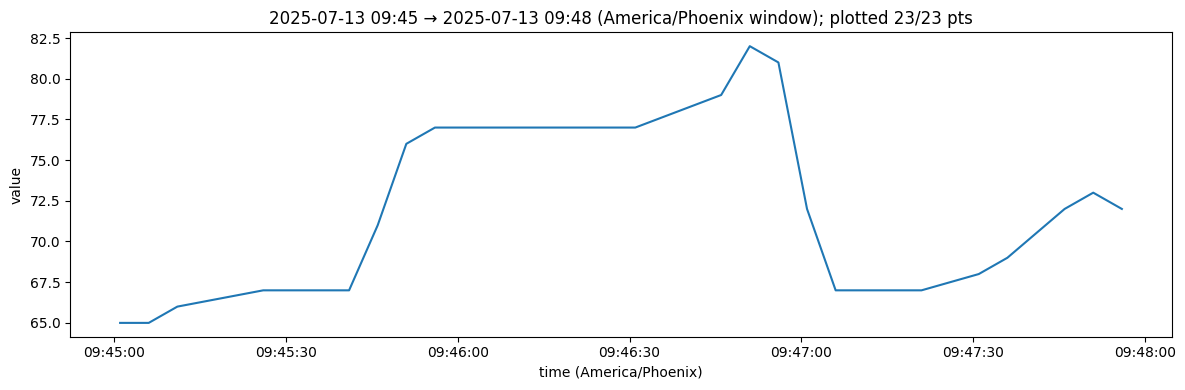

In [ ]:
# Arbitrary window, pass explicit start/end in Phoenix time
# time for sitting on toilet
plot_sensor_window(fitbitdf,
                   "2025-07-13 09:45", "2025-07-13 09:48",
                   query_tz="America/Phoenix",
                   display_tz="America/Phoenix")


/tmp/ipykernel_1454032/4061535595.py:67: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ds = df.resample(f"{bin_seconds}S").mean(numeric_only=True).dropna(how="all")


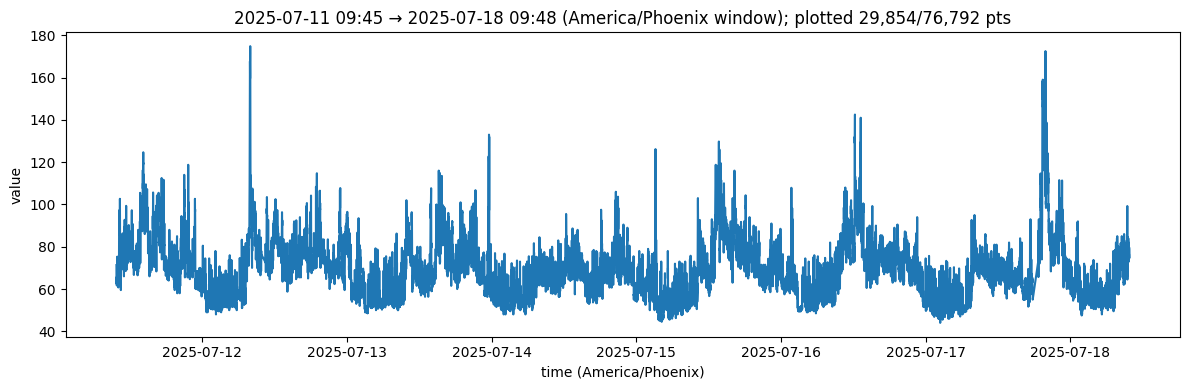

In [41]:
plot_sensor_window(fitbitdf,
                   "2025-07-11 09:45", "2025-07-18 09:48",
                   query_tz="America/Phoenix",
                   display_tz="America/Phoenix")

In [28]:
fitbitdd = ["abhik", "0", "fitbit", "charge4or5", "hr", "builtin"]
bathroomHumiditydd = ["abhik", "bathroompi", "Bosch", "bme280", "relativeHumidity", "internal"]


humdf = readWorkingTSDF(bathroomHumiditydd)


read in 10537676 rows from 26 files, retruning 10537676 rows


In [32]:
humdf.columns = ["value"]
humdf = humdf.rename_axis("sampleDT")


In [33]:
humdf

,value
sampleDT,
2025-04-11 23:28:34+00:00,39.21875
2025-04-11 23:28:35+00:00,39.5625
2025-04-11 23:28:36+00:00,39.0625
2025-04-11 23:28:37+00:00,38.96875
2025-04-11 23:28:38+00:00,39.46875
...,...
2025-08-11 23:59:55+00:00,52.46875
2025-08-11 23:59:56+00:00,52.21875
2025-08-11 23:59:57+00:00,52.5


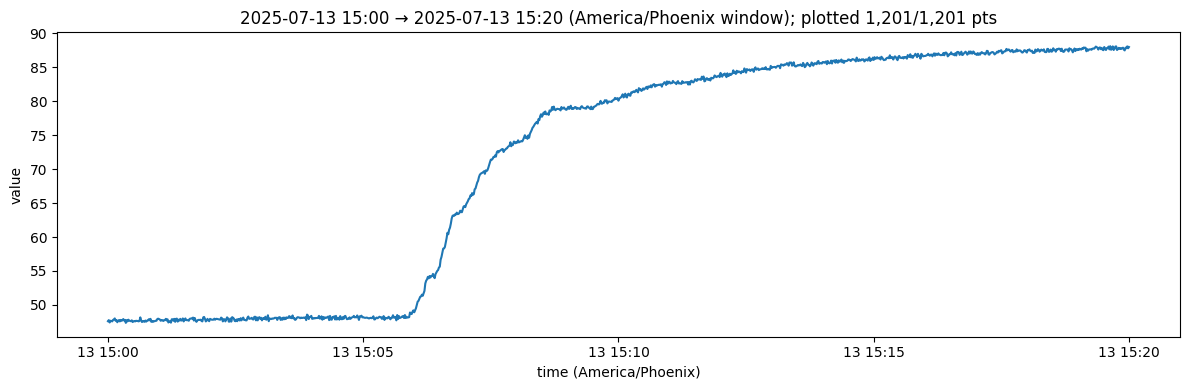

In [39]:
plot_sensor_window(humdf,
                   "2025-07-13 15:00", "2025-07-13 15:20",
                   query_tz="America/Phoenix",
                   display_tz="America/Phoenix")

/tmp/ipykernel_1454032/4061535595.py:67: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ds = df.resample(f"{bin_seconds}S").mean(numeric_only=True).dropna(how="all")


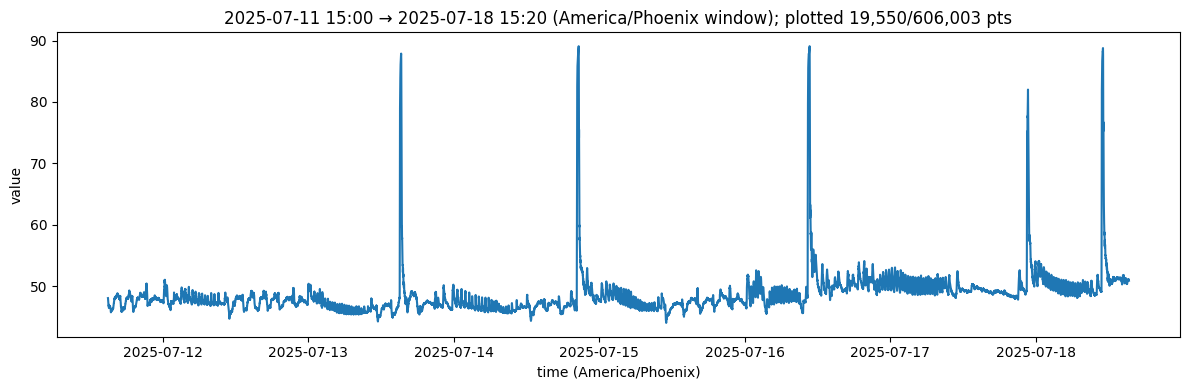

In [42]:
plot_sensor_window(humdf,
                   "2025-07-11 15:00", "2025-07-18 15:20",
                   query_tz="America/Phoenix",
                   display_tz="America/Phoenix")